In [1]:
import json
import urllib3
import time
import urllib.request
import pandas as pd
from pandas.io.json import json_normalize
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['legend.frameon'] = True

#pd.set_option('display.max_rows', 50)
#pd.set_option('display.max_columns', 50)

import seaborn as sns
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('deep')


In [2]:
def requestData(query):
    return json_normalize(json.load(urllib.request.urlopen(query))["data"]["result"])

def queryBuilder(q1):
    url   = 'http://moe.eecs.qmul.ac.uk:8888/api/v1/query?'
    query = 'query='+q1
    return url+query

#query_range?query=up&start=2015-07-01T20:10:30.781Z&end=2015-07-01T20:11:00.781Z&step=15s
def queryRangeBuilder(query,start,end):
    url   = 'http://moe.eecs.qmul.ac.uk:8888/api/v1/query_range?'
    query = 'query='+ query
    start = 'start='+ start + ".000Z"
    end   = 'end='  + end   + ".000Z"
    steps = 'step=10s' 
    return url+query+"&"+start+"&"+end+"&"+steps

def addLists(l1,l2):
    total = [0]*len(l1)
    i = 0
    for x in l1:
        total[i] = total[i] + x +l2[i]
        i+=1
    return total

def sumRows(df,col):
    length = 9999
    for row in df[col]:
        length = min(length, len(row))
    total =[0]*length
    #total =[0]*len(df[col][df.first_valid_index()])
    for index,row in df.iterrows():
        i =0
        for val in row[col]:
            if(i>=length):
                break
            total[i]=total[i]+float(val)
            i+=1
    return total

def averageRows(df,col):
    totalTests = df.shape[0]
    total =[0]*len(df[col][df.first_valid_index()])
    for index,row in df.iterrows():
        i =0
        for val in row[col]:
            total[i]=total[i]+(float(val)/totalTests)
            i+=1
    return total

def averageSet(allData):
    totalTests = len(allData)
    xMax = 9999
    yMax = 9999
    for x,y in allData:
        xMax = min(len(x),xMax)
        yMax = min(len(y),yMax)
    totalX = [0]*xMax
    totalY = [0]*yMax
    
    for x,y in allData:
        i =0
        for val in x:
            if i>=xMax:
                break
            totalX[i]=totalX[i]+(float(val)/totalTests)
            i+=1
        i =0
        for val in y:
            if i>=yMax:
                break
            totalY[i]=totalY[i]+(float(val)/totalTests)
            i+=1
    return (totalX,totalY)

def averageSetSingular(allData):
    totalTests = len(allData)
    xMax = 9999
    for x in allData:
        xMax = min(len(x),xMax)
    totalX = [0]*xMax
    for x in allData:
        i =0
        for val in x:
            if i>=xMax:
                break
            totalX[i]=totalX[i]+(float(val)/totalTests)
            i+=1
    return (totalX)

def sortData(x,y):
    sortedZip = sorted(zip(x,y), key=lambda pair: pair[0])
    return ([ a for a,b in sortedZip ], [ b for a,b in sortedZip ])


In [3]:
def oldTrial(start,end):
    mainMessages = requestData(queryRangeBuilder('raphtory_mainMessages',start,end))
    cpuUsage = requestData(queryRangeBuilder("rate(process_cpu_sum[180s])/rate(process_cpu_count[180s])",start,end))
    cpuUsage = cpuUsage[cpuUsage["metric.mode"] == "total"]
    joined = cpuUsage.merge(mainMessages, on=['metric.instance','metric.instance'], how='left')
    joined = joined[joined["metric.job_y"] == "prometheus"]
    joined["values_x"]=joined["values_x"].apply(lambda x: list(map((lambda y: y[1]),x)))
    joined["values_y"]=joined["values_y"].apply(lambda x: list(map((lambda y: y[1]),x)))
    totalCPU = sumRows(joined,"values_x")
    totalMessages = sumRows(joined,"values_y")
    return(totalCPU,totalMessages)

def mainMessages(start,end):
    mainMessages = requestData(queryRangeBuilder('raphtory_mainMessages',start,end))
    mainMessages["values"]=mainMessages["values"].apply(lambda x: list(map((lambda y: y[1]),x)))
    return(sumRows(mainMessages,"values"))

def secondaryMessages(start,end):
    secondaryMessages = requestData(queryRangeBuilder('raphtory_secondaryMessages',start,end))
    secondaryMessages["values"]=secondaryMessages["values"].apply(lambda x: list(map((lambda y: y[1]),x)))
    return(sumRows(secondaryMessages,"values"))

def workerMessages(start,end):
    workerMessages = requestData(queryRangeBuilder('raphtory_workerMessages',start,end))
    workerMessages["values"]=workerMessages["values"].apply(lambda x: list(map((lambda y: y[1]),x)))
    return(sumRows(workerMessages,"values"))

def mainPlusSecondaryMessages(start,end):
    return(addLists(mainMessages(start,end),secondaryMessages(start,end)))

def allMessages(start,end):
    return(addLists(mainPlusSecondaryMessages(start,end),workerMessages(start,end)))

def updates(start,end):
    rawUpdates = requestData(queryRangeBuilder('raphtory_benchmarker',start,end))
    rawUpdates["values"]=rawUpdates["values"].apply(lambda x: list(map((lambda y: y[1]),x)))
    rawUpdates=rawUpdates[rawUpdates["metric.name"] == "diff"]
    return(rawUpdates["values"][rawUpdates.first_valid_index()])

def cpu(start,end):
    mainMessages = requestData(queryRangeBuilder('raphtory_mainMessages',start,end))
    cpuUsage = requestData(queryRangeBuilder("rate(process_cpu_sum[180s])/rate(process_cpu_count[180s])",start,end))
    cpuUsage = cpuUsage[cpuUsage["metric.mode"] == "total"]
    cpuUsage = cpuUsage.merge(mainMessages, on=['metric.instance','metric.instance'], how='left')
    cpuUsage = cpuUsage[cpuUsage["metric.job_y"] == "prometheus"]
    cpuUsage["values_x"]=cpuUsage["values_x"].apply(lambda x: list(map((lambda y: y[1]),x)))
    totalCPU = sumRows(cpuUsage,"values_x")
    return totalCPU

def networkReceived(start,end):
    mainMessages = requestData(queryRangeBuilder('raphtory_mainMessages',start,end))
    networkUsage = requestData(queryRangeBuilder("rate(host_network_bytes_bytes_total[180s])",start,end))
    networkUsage = networkUsage[networkUsage["metric.direction"] == "received"]
    networkUsage = networkUsage.merge(mainMessages, on=['metric.instance','metric.instance'], how='left')
    networkUsage = networkUsage[networkUsage["metric.job_y"] == "prometheus"]
    networkUsage["values_x"]=networkUsage["values_x"].apply(lambda x: list(map((lambda y: y[1]),x)))
    totalNetwork = averageRows(networkUsage,"values_x")
    return totalNetwork

def networkTransmitted(start,end):
    mainMessages = requestData(queryRangeBuilder('raphtory_mainMessages',start,end))
    networkUsage = requestData(queryRangeBuilder("rate(host_network_bytes_bytes_total[180s])",start,end))
    networkUsage = networkUsage[networkUsage["metric.direction"] == "transmitted"]
    networkUsage = networkUsage.merge(mainMessages, on=['metric.instance','metric.instance'], how='left')
    networkUsage = networkUsage[networkUsage["metric.job_y"] == "prometheus"]
    networkUsage["values_x"]=networkUsage["values_x"].apply(lambda x: list(map((lambda y: y[1]),x)))
    totalNetwork = averageRows(networkUsage,"values_x")
    return totalNetwork

In [59]:
def plotIndividual(times,x,y,labelName):
    i=0
    for start,end in times:
        i+=1
        plt.plot(x(start,end), y(start,end), label=labelName+" "+str(i))
        
def plotIndividualSorted(times,x,y,labelName):
    i=0
    for start,end in times:
        i+=1
        data = sortData(x(start,end), y(start,end))
        plt.plot(data[0],data[1], label=labelName+" "+str(i))  
        
def plotAverage(times,x,y,labelName):
    allData =[]
    for start,end in times:
        allData.append((x(start,end),y(start,end)))
    averageX, averageY = averageSet(allData)
    if(len(averageX)>len(averageY)):
        averageX = averageX[:-1]
    if(len(averageY)>len(averageX)):
        averageY = averageY[:-1]
    plt.plot(averageX, averageY,label=labelName)
    
def plotAverageSorted(times,x,y,labelName):
    allData =[]
    for start,end in times:
        allData.append(sortData(x(start,end),y(start,end)))
    averageX, averageY = averageSet(allData)
    plt.plot(averageX, averageY,label=labelName)
    
def plotMax(times,labels,func,mainlabel):
    ydata =[0]*len(times)
    yError =[0]*len(times)
    i =0
    for time in times:
        allData =[]
        maxEach = []
        for start,end in time:
            data = func(start,end)
            allData.append(data)
            maxEach.append(max(map(lambda x: int(x),data)))
        ydata[i] = max(averageSetSingular(allData))
        yError[i]= np.std(np.array(maxEach))
        i+=1
    plt.errorbar(labels,ydata,yerr=yError,linestyle='--', marker='o',label=mainlabel)

def plotMaxRatio(times,labels,func1,func2,mainlabel):
    ydata =[0]*len(times)
    yError =[0]*len(times)
    i =0
    for time in times:
        allData1 =[]
        maxEach1 = []
        allData2 =[]
        maxEach2 = []
        for start,end in time:
            data1 = func1(start,end)
            data2 = func2(start,end)
            allData1.append(data1)
            maxEach1.append(max(map(lambda x: int(x),data1)))
            allData2.append(data2)
            maxEach2.append(max(map(lambda x: int(x),data2)))
        ydata[i] = max(1,max(averageSetSingular(allData1)))/max(1,max(averageSetSingular(allData2)))
        #yError[i]= np.std(np.array(maxEach1))/np.std(np.array(maxEach2))
        i+=1
    plt.plot(labels,ydata,linestyle='--', marker='o',label=mainlabel)

def subplotMax(ax,times,labels,func,mainlabel):
    ydata =[0]*len(times)
    yError =[0]*len(times)
    i =0
    for time in times:
        allData =[]
        maxEach = []
        for start,end in time:
            data = func(start,end)
            allData.append(data)
            maxEach.append(max(map(lambda x: int(x),data)))
        ydata[i] = max(averageSetSingular(allData))
        yError[i]= np.std(np.array(maxEach))
        i+=1
    ax.errorbar(labels,ydata,yerr=yError,linestyle='--', marker='o',label=mainlabel)

In [79]:
Write1 = []
Write1.append(("2019-05-30T22:05:08","2019-05-30T22:16:20"))
Write1.append(("2019-05-30T22:24:16","2019-05-30T22:35:56"))
Write1.append(("2019-05-30T22:43:24","2019-05-30T22:54:36"))
Write1.append(("2019-05-30T23:02:04","2019-05-30T23:13:34"))
Write1.append(("2019-05-30T23:21:12","2019-05-30T23:32:24"))

Archive1 = []
Archive1.append(("2019-05-30T23:40:08","2019-05-30T23:51:20"))
Archive1.append(("2019-05-30T23:59:16","2019-05-31T00:10:28"))
Archive1.append(("2019-05-31T00:18:24","2019-05-31T00:27:44"))
Archive1.append(("2019-05-31T00:35:28","2019-05-31T00:46:40"))
Archive1.append(("2019-05-31T00:54:08","2019-05-31T01:03:56"))

compress1 = []
compress1.append(("2019-05-31T01:11:12","2019-05-31T01:20:32"))
compress1.append(("2019-05-31T01:27:04","2019-05-31T01:36:24"))
compress1.append(("2019-05-31T01:43:24","2019-05-31T01:52:16"))
compress1.append(("2019-05-31T01:59:16","2019-05-31T02:08:08"))
compress1.append(("2019-05-31T02:15:08","2019-05-31T02:24:56"))

#save1 = []
#save1.append(("2019-05-31T02:32:24","2019-05-31T02:39:52"))
#save1.append(("2019-05-31T02:51:32","2019-05-31T02:58:04"))
#save1.append(("2019-05-31T03:11:08","2019-05-31T03:17:40"))
#save1.append(("2019-05-31T03:32:24","2019-05-31T03:37:32"))
#save1.append(("2019-05-31T03:48:16","2019-05-31T03:55:16"))

save1 = []
save1.append(("2019-06-09T21:02:03","2019-06-09T21:11:17"))
save1.append(("2019-06-09T21:17:07","2019-06-09T21:26:13"))
save1.append(("2019-06-09T21:32:03","2019-06-09T21:41:43"))
save1.append(("2019-06-09T21:47:07","2019-06-09T21:56:27"))
save1.append(("2019-06-09T22:02:11","2019-06-09T22:11:02"))


Write2 = []
Write2.append(("2019-05-31T21:27:19","2019-05-31T21:40:51"))
Write2.append(("2019-05-31T21:48:14","2019-05-31T22:01:26"))
Write2.append(("2019-05-31T22:09:22","2019-05-31T22:22:40"))
Write2.append(("2019-05-31T22:30:30","2019-05-31T22:43:48"))
Write2.append(("2019-05-31T22:51:16","2019-05-31T23:04:56"))

Archive2 = []
Archive2.append(("2019-05-31T23:12:08","2019-05-31T23:25:12"))
Archive2.append(("2019-05-31T23:31:16","2019-05-31T23:44:08"))
Archive2.append(("2019-05-31T23:51:20","2019-06-01T00:02:32"))
Archive2.append(("2019-06-01T00:09:04","2019-06-01T00:20:44"))
Archive2.append(("2019-06-01T00:28:12","2019-06-01T00:40:48"))

compress2 = []
compress2.append(("2019-06-01T00:49:00","2019-06-01T00:59:16"))
compress2.append(("2019-06-01T01:06:16","2019-06-01T01:17:00"))
compress2.append(("2019-06-01T01:25:24","2019-06-01T01:36:08"))
compress2.append(("2019-06-01T01:43:24","2019-06-01T01:55:32"))
compress2.append(("2019-06-01T02:02:32","2019-06-01T02:13:16"))

#save2 = []
#save2.append(("2019-06-01T02:20:28","2019-06-01T02:36:08"))
#save2.append(("2019-06-01T02:42:12","2019-06-01T02:56:40"))
#save2.append(("2019-06-01T03:04:36","2019-06-01T03:18:36"))
#save2.append(("2019-06-01T03:24:12","2019-06-01T03:39:08"))
#save2.append(("2019-06-01T03:45:28","2019-06-01T04:01:20"))
save2 = []
save2.append(("2019-06-09T19:32:13","2019-06-09T19:42:53"))
save2.append(("2019-06-09T19:50:11","2019-06-09T20:01:30"))
save2.append(("2019-06-09T20:08:12","2019-06-09T20:18:52"))
save2.append(("2019-06-09T20:26:06","2019-06-09T20:37:00"))
save2.append(("2019-06-09T20:44:19","2019-06-09T20:55:13"))

Write4 = []
Write4.append(("2019-06-01T04:07:12","2019-06-01T04:25:24"))
Write4.append(("2019-06-01T04:32:24","2019-06-01T04:50:36"))
Write4.append(("2019-06-01T04:57:08","2019-06-01T05:15:20"))
Write4.append(("2019-06-01T05:22:20","2019-06-01T05:41:00"))
Write4.append(("2019-06-01T05:47:20","2019-06-01T06:05:42"))

Archive4 = []
Archive4.append(("2019-06-01T06:12:20","2019-06-01T06:28:40"))
Archive4.append(("2019-06-01T06:35:12","2019-06-01T06:52:56"))
Archive4.append(("2019-06-01T06:59:28","2019-06-01T07:15:48"))
Archive4.append(("2019-06-01T07:22:20","2019-06-01T07:39:08"))
Archive4.append(("2019-06-01T07:46:24","2019-06-01T08:03:40"))

compress4 = []
compress4.append(("2019-06-01T08:11:08","2019-06-01T08:26:40"))
compress4.append(("2019-06-01T08:33:04","2019-06-01T08:47:48"))
compress4.append(("2019-06-01T08:54:20","2019-06-01T09:09:16"))
compress4.append(("2019-06-01T09:16:16","2019-06-01T09:31:21"))
compress4.append(("2019-06-01T09:38:12","2019-06-01T09:52:56"))

save4 = []
save4.append(("2019-06-09T17:49:11","2019-06-09T18:02:01"))
save4.append(("2019-06-09T18:08:03","2019-06-09T18:23:09"))
save4.append(("2019-06-09T18:29:30","2019-06-09T18:44:17"))
save4.append(("2019-06-09T18:50:07","2019-06-09T19:05:23"))
save4.append(("2019-06-09T19:11:15","2019-06-09T19:26:11"))

Write8 = []
Write8.append(("2019-06-01T11:44:20","2019-06-01T12:08:08"))
Write8.append(("2019-06-01T12:15:08","2019-06-01T12:38:56"))
Write8.append(("2019-06-01T12:46:12","2019-06-01T13:10:10"))
Write8.append(("2019-06-01T13:17:28","2019-06-01T13:41:45"))
Write8.append(("2019-06-01T13:48:04","2019-06-01T14:12:20"))

Archive8 = []
Archive8.append(("2019-06-01T14:19:20","2019-06-01T14:40:20"))
Archive8.append(("2019-06-01T14:47:08","2019-06-01T15:07:40"))
Archive8.append(("2019-06-01T15:15:08","2019-06-01T15:36:36"))
Archive8.append(("2019-06-01T15:43:24","2019-06-01T16:04:52"))
Archive8.append(("2019-06-01T16:12:24","2019-06-01T16:33:48"))

compress8 = []
compress8.append(("2019-06-01T16:40:20","2019-06-01T16:59:16"))
compress8.append(("2019-06-01T17:06:16","2019-06-01T17:26:20"))
compress8.append(("2019-06-01T17:32:12","2019-06-01T17:52:16"))
compress8.append(("2019-06-01T17:59:16","2019-06-01T18:18:52"))
compress8.append(("2019-06-01T18:26:08","2019-06-01T18:45:16"))

save8 = []
save8.append(("2019-06-09T15:26:10","2019-06-09T15:43:40"))
save8.append(("2019-06-09T16:08:08","2019-06-09T16:26:30"))
save8.append(("2019-06-09T16:33:03","2019-06-09T16:50:50"))
save8.append(("2019-06-09T16:58:02","2019-06-09T17:16:20"))
save8.append(("2019-06-09T17:23:05","2019-06-09T17:42:50"))

writeSet = [Write1,Write2,Write4,Write8]
archiveSet = [Archive1,Archive2,Archive4,Archive8]
compressSet=[compress1,compress2,compress4,compress8]
saveSet=[save1,save2,save4,save8]
#plotAverage(Archive2,cpu,mainMessages,"2 Partition Managers Archiving")

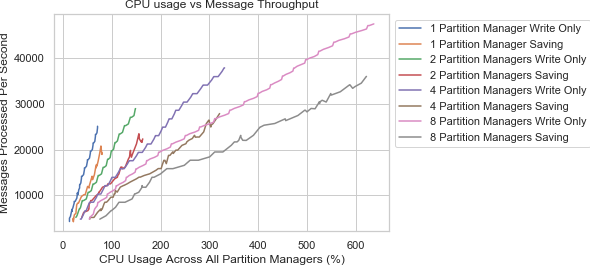

In [87]:
plt.tight_layout()
plt.title('CPU usage vs Message Throughput')
plt.xlabel('CPU Usage Across All Partition Managers (%)')
plt.ylabel('Messages Processed Per Second')
plotAverageSorted(Write1,cpu,updates,"1 Partition Manager Write Only")
#plotAverage(Archive1,cpu,updates,"1 Partition Manager Archiving")
#plotAverage(compress1,cpu,updates,"1 Partition Manager Compressing")
plotAverageSorted(save1,cpu,updates,"1 Partition Manager Saving")
plotAverageSorted(Write2,cpu,updates,"2 Partition Managers Write Only")
#plotAverage(Archive2,cpu,updates,"2 Partition Managers Archiving")
#plotAverage(compress2,cpu,updates,"2 Partition Managers Compressing")
plotAverageSorted(save2,cpu,updates,"2 Partition Managers Saving")
plotAverageSorted(Write4,cpu,updates,"4 Partition Managers Write Only")
#plotAverage(Archive4,cpu,updates,"4 Partition Managers Archiving")
#plotAverage(compress4,cpu,updates,"4 Partition Managers Compressing")
plotAverageSorted(save4,cpu,updates,"4 Partition Managers Saving")
plotAverageSorted(Write8,cpu,updates,"8 Partition Managers Write Only")
#plotAverage(Archive8,cpu,updates,"8 Partition Managers Archiving")
#plotAverage(compress8,cpu,updates,"8 Partition Managers Compressing")
plotAverageSorted(save8,cpu,updates,"8 Partition Managers Saving")

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

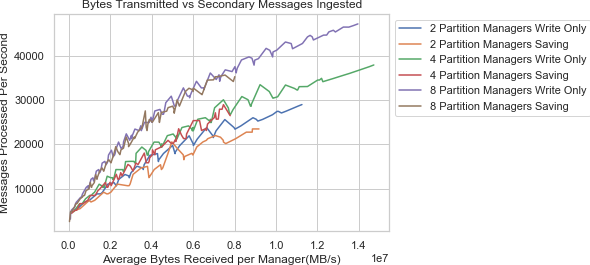

In [86]:
plt.tight_layout()
plt.title('Bytes Transmitted vs Secondary Messages Ingested')
plt.xlabel('Average Bytes Received per Manager(MB/s)')
plt.ylabel('Messages Processed Per Second')
plotAverageSorted(Write2,networkTransmitted,updates,"2 Partition Managers Write Only")
#plotAverageSorted(Archive2,networkTransmitted,updates,"2 Partition Managers Archiving")
#plotAverageSorted(compress2,networkTransmitted,updates,"2 Partition Managers Compressing")
plotAverageSorted(save2,networkTransmitted,updates,"2 Partition Managers Saving")

plotAverageSorted(Write4,networkTransmitted,updates,"4 Partition Managers Write Only")
#plotAverageSorted(Archive4,networkTransmitted,updates,"4 Partition Managers Archiving")
#plotAverageSorted(compress4,networkTransmitted,updates,"4 Partition Managers Compressing")
plotAverageSorted(save4,networkTransmitted,updates,"4 Partition Managers Saving")


plotAverageSorted(Write8,networkTransmitted,updates,"8 Partition Managers Write Only")
#plotAverageSorted(Archive8,networkTransmitted,updates,"8 Partition Managers Archiving")
#plotAverageSorted(compress8,networkTransmitted,updates,"8 Partition Managers Compressing")
plotAverageSorted(save8,networkTransmitted,updates,"8 Partition Managers Saving")

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

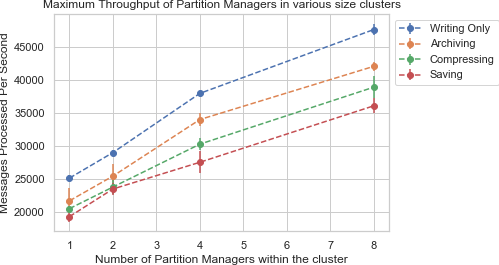

In [80]:
plt.tight_layout()
plt.title('Maximum Throughput of Partition Managers in various size clusters')
plt.xlabel('Number of Partition Managers within the cluster')
plt.ylabel('Messages Processed Per Second')
plotMax(writeSet,[1,2,4,8],updates,"Writing Only")
plotMax(archiveSet,[1,2,4,8],updates,"Archiving")
plotMax(compressSet,[1,2,4,8],updates,"Compressing")
plotMax(saveSet,[1,2,4,8],updates,"Saving")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

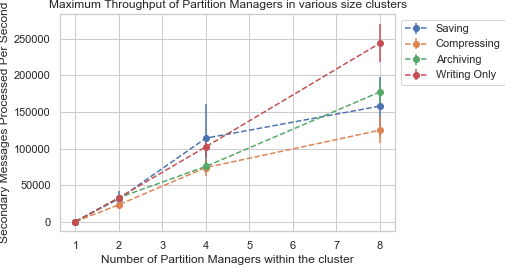

In [81]:
plt.tight_layout()
plt.title('Maximum Throughput of Partition Managers in various size clusters')
plt.xlabel('Number of Partition Managers within the cluster')
plt.ylabel('Secondary Messages Processed Per Second')
plotMax(saveSet,[1,2,4,8],secondaryMessages,"Saving")
plotMax(compressSet,[1,2,4,8],secondaryMessages,"Compressing")
plotMax(archiveSet,[1,2,4,8],secondaryMessages,"Archiving")
plotMax(writeSet,[1,2,4,8],secondaryMessages,"Writing Only")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

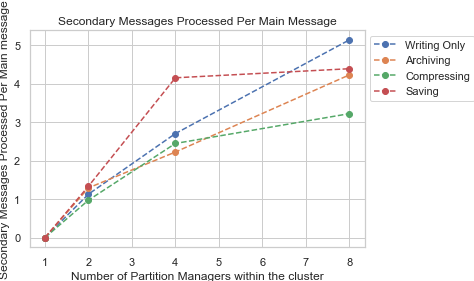

In [82]:
plt.tight_layout()
plt.title('Secondary Messages Processed Per Main Message')
plt.xlabel('Number of Partition Managers within the cluster')
plt.ylabel('Secondary Messages Processed Per Main message')
plotMaxRatio(writeSet,[1,2,4,8],secondaryMessages,updates,"Writing Only")
plotMaxRatio(archiveSet,[1,2,4,8],secondaryMessages,updates,"Archiving")
plotMaxRatio(compressSet,[1,2,4,8],secondaryMessages,updates,"Compressing")
plotMaxRatio(saveSet,[1,2,4,8],secondaryMessages,updates,"Saving")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

In [48]:
def plotStack(times,labels,func1,func2,mainlabel):
    bar1 =[0]*len(times)
    bar2 =[0]*len(times)
    i =0
    for time in times:
        allData1 =[]
        allData2 =[]
        for start,end in time:
            allData1.append(func1(start,end))
            allData2.append(func2(start,end))
        bar1[i] = max(averageSetSingular(allData1))
        bar2[i] = max(averageSetSingular(allData2))
        i+=1
    bar1 = (np.array(bar1))
    bar2 = (np.array(bar2))
    ind = np.arange(len(times))
    width = 0.4
    plt.bar(ind,bar1, width)
    plt.bar(ind,bar2, width, bottom=bar1)
        

plotStack(writeSet,[1,2,4,8],mainMessages,secondaryMessages,"Writing Only")

#plt.tight_layout()
#plt.title('Maximum Throughput of Partition Managers in various size clusters')
#plt.xlabel('Number of Partition Managers within the cluster')
#plt.ylabel('Messages Processed Per Second')

#subplotMax(ax1,writeSet,[1,2,4,8],updates,"Writing Only")
#subplotMax(ax1,archiveSet,[1,2,4,8],updates,"Archiving")
#subplotMax(ax1,compressSet,[1,2,4,8],updates,"Compressing")
#subplotMax(ax2,writeSet,[1,2,4,8],secondaryMessages,"Writing Only")
#subplotMax(ax2,archiveSet,[1,2,4,8],secondaryMessages,"Archiving")
#subplotMax(ax2,compressSet,[1,2,4,8],secondaryMessages,"Compressing")
#plt.legend(loc="upper left", bbox_to_anchor=(1,1))

#f.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

In [49]:
#f, axarr = plt.subplots(2, 2)

#subplotMax(axarr[0, 0],writeSet,[1,2,4,8],updates,"Writing Only")
#subplotMax(axarr[0, 0],archiveSet,[1,2,4,8],updates,"Archiving")
#subplotMax(axarr[0, 0],compressSet,[1,2,4,8],updates,"Compressing")
##subplotMax(axarr[0, 1],writeSet,[1,2,4,8],secondaryMessages,"Writing Only")
#subplotMax(axarr[0, 1],archiveSet,[1,2,4,8],secondaryMessages,"Archiving")
#subplotMax(axarr[0, 1],compressSet,[1,2,4,8],secondaryMessages,"Compressing")
#plt.legend(loc="upper left", bbox_to_anchor=(1,1))

#axarr[0, 0].plot(x, y)
#axarr[0, 0].set_title('Axis [0,0]')
#axarr[0, 1].scatter(x, y)
##axarr[0, 1].set_title('Axis [0,1]')
#axarr[1, 0].plot(x, y ** 2,colspan=2)
#axarr[1, 0].set_title('Axis [1,0]')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
#plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
#plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)